# 🔄 Online learning for time series prediction 🔄


In [1], the authors develop an online learning method to predict time-series
generated by and ARMA (autoregressive moving average) model.

They develop an effective online learning algorithm based on an **improper learning** approach which consists to use an AR model for prediction with sufficiently long horizon, together with an online update of the prediction model parameters using either an "online Newton" algorithm [2] or a stochastic gradient descent algorithm.

This effective approach adresses the prediction problem, without assuming that the noise terms are Gaussian, identically distributed or even independent.
Furthermore, they show that their algorithm’s performances asymptotically approaches the performance of the best ARMA model in hindsight.

We use WAX-ML to reproduce their empirical results.

We first focus in the reproduction of the "setting 1" for sanity checks and show how to setup a training environment with WAX-ML to study improper learning of ARMA time-series models.

We then study the behavior the method with different optimizers in the non-stationary environements proposed in [1] (settings 2, 3, and 4).

We use the following modules from WAX-ML:
  * ARMA : to generate a modeled time-series
  * SNARIMAX : to adaptively learn to predict the generated time-series.
  * GymFeedback: To setup a training loop.
  * VMap: to add batch dimensions to the training loop
  * optim.newton: a newton algorithm as used in [1] and developped in [2]. It extends `optax` optimizers.
  * OnlineOptimizer: A wrapper for a model with loss and and optimizer for online learning.

## References

[1] [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June. Online learning for time series prediction. In Conference on learning theory (pp. 172-184)](https://arxiv.org/pdf/1302.6927.pdf)

[2] [Hazan, E., Agarwal, A. and Kale, S., 2007. Logarithmic regret algorithms for
online convex optimization. Machine Learning, 69(2-3), pp.169-192](https://link.springer.com/content/pdf/10.1007/s10994-007-5016-8.pdf)

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [52]:
from typing import Any, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from wax.modules import (
    ARMA,
    SNARIMAX,
    GymFeedback,
    Lag,
    OnlineOptimizer,
    UpdateParams,
    VMap,
)
from wax.optim import newton
from wax.unroll import unroll_transform_with_state

In [3]:
T = 10000
N_BATCH = 20
N_STEP_SIZE = 10
N_EPS = 5

## ARMA


Let's generate a sample of the "setting 1" of [1]:

<AxesSubplot:>

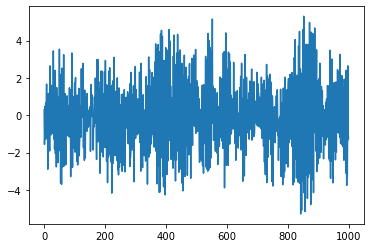

In [4]:
alpha = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
beta = jnp.array([0.3, -0.2])

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
sim = unroll_transform_with_state(lambda eps: ARMA(alpha, beta)(eps))
params, state = sim.init(rng, eps)
y, state = sim.apply(params, state, rng, eps)
pd.Series(y).plot()

## SNARIMAX


Let's setup an online model to try to learn the dynamic of the time-series.

First let's run the filter with it's initial random weights.

<AxesSubplot:>

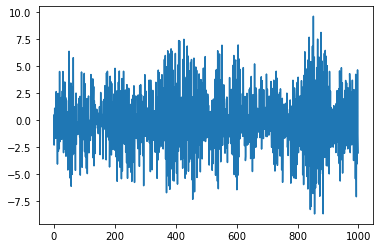

In [5]:
def predict(y, X=None):
    return SNARIMAX(10, 0, 0)(y, X)


sim = unroll_transform_with_state(predict)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10,))
params, state = sim.init(rng, y)
(y_pred, _), state = sim.apply(params, state, rng, y)

pd.Series((y - y_pred)).plot()

In [6]:
def evaluate(y_pred, y):
    return jnp.linalg.norm(y_pred - y) ** 2, {}


def lag(shift=1):
    def __call__(y, X=None):
        yp = Lag(shift)(y)
        Xp = Lag(shift)(X) if X is not None else None
        return yp, Xp

    return __call__


def predict_and_evaluate(y, X=None):
    # predict with lagged data
    y_pred, pred_info = predict(*lag(1)(y, X))

    # evaluate loss with actual data
    loss, loss_info = evaluate(y_pred, y)

    return loss, dict(pred_info=pred_info, loss_info=loss_info)

<AxesSubplot:>

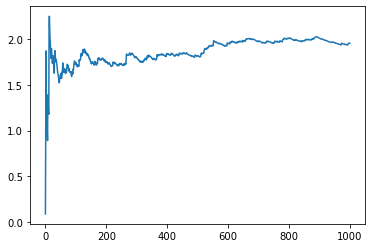

In [7]:
sim = unroll_transform_with_state(predict_and_evaluate)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(loss, _), state = sim.apply(params, state, rng, y)

pd.Series(loss).expanding().mean().plot()

Since the model is not trained and the coefficient of the SNARIMAX filter a choosen randomly, the loss may diverge

In [8]:
params

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'w': DeviceArray([[-0.47023755],
                                           [ 0.07070494],
                                           [-0.07388116],
                                           [ 0.13453043],
                                           [ 0.07728617],
                                           [ 0.0851969 ],
                                           [-0.03324771],
                                           [ 0.17115903],
                                           [ 0.1023274 ],
                                           [-0.4804019 ]], dtype=float32),
                         'b': DeviceArray([0.], dtype=float32),
                       }),
})

## Learn

To learn the model parameters we will use the `OnlineOptimizer` of WAX-ML.

### Setup projection

We can setup a projection for the parameters:



In [9]:
def project_params(params, opt_state=None):
    w = params["snarimax/~/linear"]["w"]
    w = jnp.clip(w, -1, 1)
    params["snarimax/~/linear"]["w"] = w
    return params

In [10]:
project_params(hk.data_structures.to_mutable_dict(params))

{'snarimax/~/linear': {'w': DeviceArray([[-0.47023755],
               [ 0.07070494],
               [-0.07388116],
               [ 0.13453043],
               [ 0.07728617],
               [ 0.0851969 ],
               [-0.03324771],
               [ 0.17115903],
               [ 0.1023274 ],
               [-0.4804019 ]], dtype=float32),
  'b': DeviceArray([0.], dtype=float32)}}

In [11]:
def learn(y, X=None):
    opt_info = OnlineOptimizer(
        predict_and_evaluate,
        optax.sgd(1.0e-2),
        project_params=project_params,
        return_params=True,
    )(y, X)
    return opt_info

Let's train:

<AxesSubplot:>

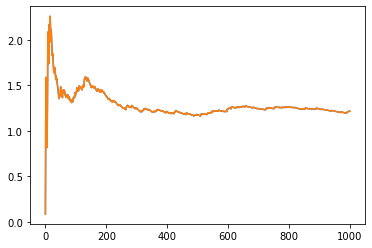

In [12]:
sim = unroll_transform_with_state(learn)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))

params, state = sim.init(rng, eps)
(opt_info), state = sim.apply(params, state, rng, eps)

pd.Series(opt_info.loss).expanding().mean().plot()
pd.Series(opt_info.opt_loss).expanding().mean().plot()

Let's look at the latest weights:

In [13]:
jax.tree_map(lambda x: x[-1], opt_info.params)

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'b': DeviceArray([-0.12306868], dtype=float32),
                         'w': DeviceArray([[-0.0333882 ],
                                           [ 0.05451486],
                                           [-0.12005502],
                                           [-0.0359183 ],
                                           [-0.07967855],
                                           [-0.02501435],
                                           [-0.1301034 ],
                                           [-0.05778565],
                                           [-0.00356861],
                                           [ 0.01641201]], dtype=float32),
                       }),
})

## Learn and Forecast




In [14]:
class ForecastInfo(NamedTuple):
    optim: Any
    forecast: Any

In [15]:
def learn_and_forecast(y, X=None):
    opt_info = OnlineOptimizer(
        predict_and_evaluate,
        optax.sgd(1.0e-3),
        project_params=project_params,
        return_params=True,
    )(*lag(1)(y, X))

    forecast, forecast_info = UpdateParams(predict)(opt_info.params, y, X)
    return forecast, ForecastInfo(opt_info, forecast_info)

<AxesSubplot:>

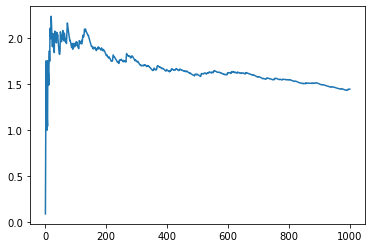

In [16]:
sim = unroll_transform_with_state(learn_and_forecast)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(forecast, info), state = sim.apply(params, state, rng, y)

pd.Series(info.optim.loss).expanding().mean().plot()

## Gym simulation

Now let's wrapup the training loop in a gym feedback loop.



### Environment


Let's build an environment corresponding to "setting 1" in [1]



In [17]:
def build_env():
    def env(action, obs):
        y_pred, eps = action, obs
        ar_coefs = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ma_coefs = jnp.array([0.3, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env

In [18]:
env = build_env()

### Agent

Let's build an agent:

In [19]:
from optax._src.base import OptState

In [20]:
def build_agent(time_series_model=None, opt=None):
    if time_series_model is None:
        time_series_model = lambda y, X: SNARIMAX(10)(y, X)

    if opt is None:
        opt = optax.sgd(1.0e-3)

    class AgentInfo(NamedTuple):
        optim: Any
        forecast: Any

    class ModelWithLossInfo(NamedTuple):
        pred: Any
        loss: Any

    def agent(obs):
        if isinstance(obs, tuple):
            y, X = obs
        else:
            y = obs
            X = None

        def evaluate(y_pred, y):
            return jnp.linalg.norm(y_pred - y) ** 2, {}

        def model_with_loss(y, X=None):
            # predict with lagged data
            y_pred, pred_info = time_series_model(*lag(1)(y, X))

            # evaluate loss with actual data
            loss, loss_info = evaluate(y_pred, y)

            return loss, ModelWithLossInfo(pred_info, loss_info)

        def project_params(params: Any, opt_state: OptState = None):
            del opt_state
            return jax.tree_map(lambda w: jnp.clip(w, -1, 1), params)

        def split_params(params):
            def filter_params(m, n, p):
                # print(m, n, p)
                return m.endswith("snarimax/~/linear") and n == "w"

            return hk.data_structures.partition(filter_params, params)

        def learn_and_forecast(y, X=None):
            opt_info = OnlineOptimizer(
                model_with_loss,
                opt,
                project_params=project_params,
                split_params=split_params,
                return_params=True,
            )(*lag(1)(y, X))

            y_pred, forecast_info = UpdateParams(time_series_model)(
                opt_info.params, y, X
            )
            return y_pred, AgentInfo(opt_info, forecast_info)

        return learn_and_forecast(y, X)

    return agent

In [21]:
agent = build_agent()

### Gym loop




In [22]:
def gym_loop(eps):
    return GymFeedback(agent, env)(eps)

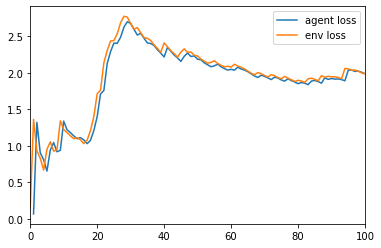

In [23]:
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (T,))
sim = unroll_transform_with_state(gym_loop)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)
pd.Series(info.agent.optim.loss).expanding().mean().plot(label="agent loss")
pd.Series(-gym.reward).expanding().mean().plot(xlim=(0, 100), label="env loss")
plt.legend()

<AxesSubplot:>

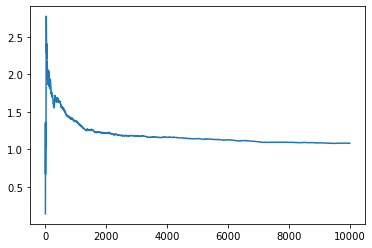

In [24]:
pd.Series(-gym.reward).expanding().mean().plot()  # ylim=(0.09, 0.15))

We see that the agent suffers the same loss as the environment but with a time lag.

## Batch simulations

### Average over 20 experiments

### Slow version

First, let's do it "naively" by doing a simple python "for loop".

In [25]:
%%time
rng = jax.random.PRNGKey(42)
sim = unroll_transform_with_state(gym_loop)

res = {}
for i in tqdm(onp.arange(N_BATCH)):
    rng, _ = jax.random.split(rng)
    eps = jax.random.normal(rng, (T,)) * 0.3
    params, state = sim.init(rng, eps)
    (gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)
    res[i] = gym_info

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4.61 s, sys: 149 ms, total: 4.76 s
Wall time: 5.57 s


<AxesSubplot:>

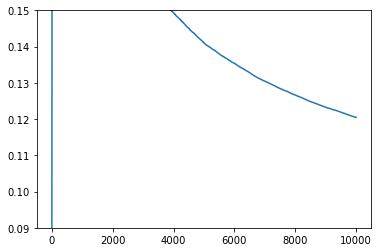

In [26]:
pd.DataFrame({k: pd.Series(v.agent.optim.loss) for k, v in res.items()}).mean(
    1
).expanding().mean().plot(ylim=(0.09, 0.15))

### Fast version with vmap

Instead of using a "for loop" we can use jax's vmap transformation function!


In [27]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (N_BATCH, T)) * 0.3

rng = jax.random.PRNGKey(42)
rng = jax.random.split(rng, num=N_BATCH)
sim = unroll_transform_with_state(gym_loop)
params, state = jax.vmap(sim.init)(rng, eps)
(gym_output, gym_info), final_state = jax.vmap(sim.apply)(params, state, rng, eps)

CPU times: user 2.67 s, sys: 103 ms, total: 2.77 s
Wall time: 2.62 s


This is much faster!

<AxesSubplot:>

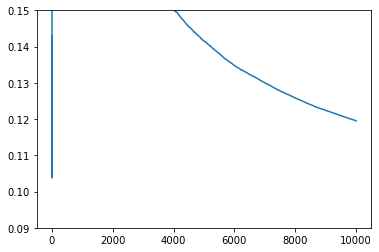

In [28]:
pd.DataFrame(gym_info.agent.optim.loss).mean().expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

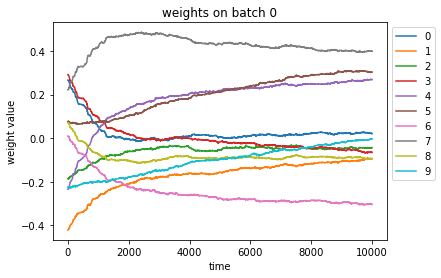

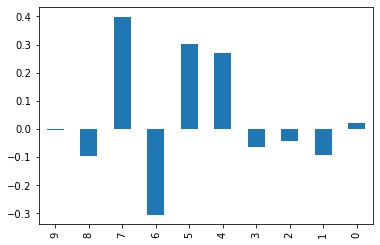

In [29]:
i_batch = 0
w = gym_info.agent.optim.params["snarimax/~/linear"]["w"][i_batch, :, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

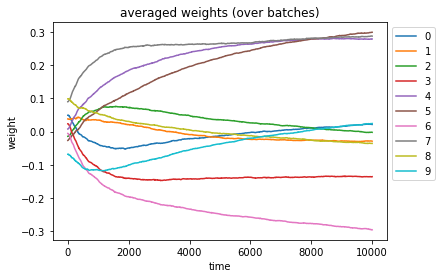

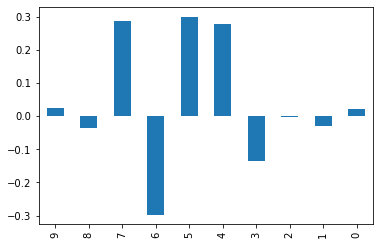

In [30]:
w = gym_info.agent.optim.params["snarimax/~/linear"]["w"].mean(axis=0)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

### With VMap module

We can use the wrapper module `VMap` of WAX-ML. It permits to have an ever simpler syntax.


> Note: we have to swap the position of time and batch dimensions in the generation of the noise variable `eps`.

In [31]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3


def batched_gym_loop(eps):
    return VMap(gym_loop)(eps)


sim = unroll_transform_with_state(batched_gym_loop)

rng = jax.random.PRNGKey(43)
params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.79 s, sys: 30.2 ms, total: 1.82 s
Wall time: 1.85 s


In [32]:
pd.DataFrame(gym_info.agent.optim.loss).shape

(10000, 20)

<AxesSubplot:>

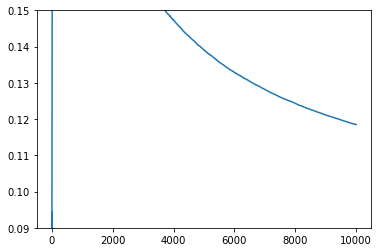

In [33]:
pd.DataFrame(gym_info.agent.optim.loss).mean(1).expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

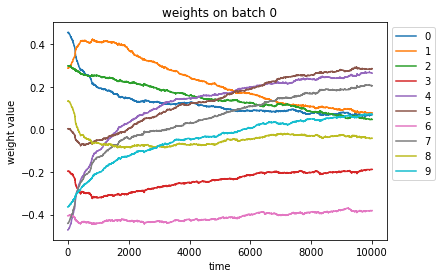

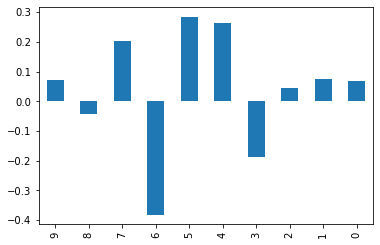

In [34]:
i_batch = 0
w = gym_info.agent.optim.params["snarimax/~/linear"]["w"][:, i_batch, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

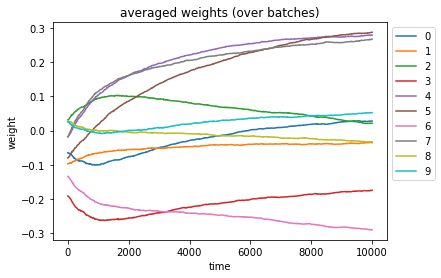

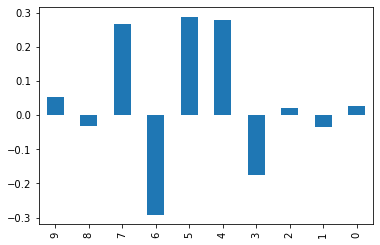

In [35]:
w = gym_info.agent.optim.params["snarimax/~/linear"]["w"].mean(axis=1)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

### Taking mean inside simulation

In [36]:
%%time


def add_batch(fun, take_mean=True):
    def fun_batch(*args, **kwargs):
        res = VMap(fun)(*args, **kwargs)
        if take_mean:
            res = jax.tree_map(lambda x: x.mean(axis=0), res)
        return res

    return fun_batch


gym_loop_batch = add_batch(gym_loop)
sim = unroll_transform_with_state(gym_loop_batch)

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3

params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.6 s, sys: 23.9 ms, total: 1.62 s
Wall time: 1.62 s


<AxesSubplot:>

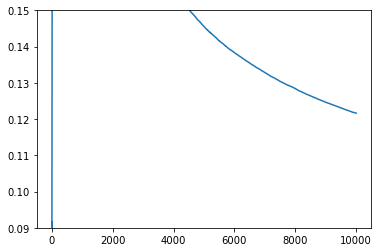

In [37]:
pd.Series(-gym_output.reward).expanding().mean().plot(ylim=(0.09, 0.15))

<AxesSubplot:>

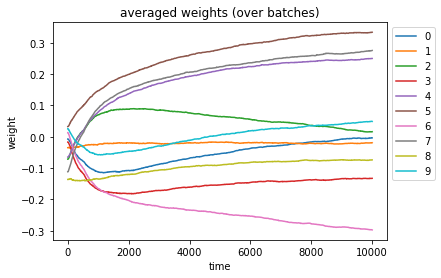

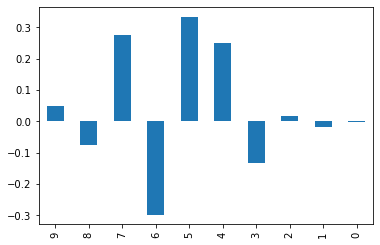

In [38]:
w = gym_info.agent.optim.params["snarimax/~/linear"]["w"][:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

## Hyper parameter tuning

### First order optimizers

We will consider different first order optimizers, namely:
- SGD
- ADAM
- ADAGRAD

For each of them, we will scan the "step_size" parameter $\eta$.

We will average results over batches of size 40.

We will consider trajectories of size 10.000.

Finally, we will pickup the best parameter based of the minimum averaged loss for the last 5000 time steps.

In [39]:
%%time

STEP_SIZE_idx = pd.Index(onp.logspace(-4, 1, 30), name="step_size")
STEP_SIZE = jax.device_put(STEP_SIZE_idx.values)
OPTIMIZERS = [optax.sgd, optax.adagrad, optax.rmsprop, optax.adam]

res = {}
for optimizer in tqdm(OPTIMIZERS):

    def gym_loop_scan_hparams(eps):
        def scan_params(step_size):
            return GymFeedback(build_agent(opt=optimizer(step_size)), env)(eps)

        res = VMap(scan_params)(STEP_SIZE)
        return res

    sim = unroll_transform_with_state(add_batch(gym_loop_scan_hparams))
    rng = jax.random.PRNGKey(42)
    eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3

    params, state = sim.init(rng, eps)
    _res, state = sim.apply(params, state, rng, eps)
    res[optimizer.__name__] = _res

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 12.6 s, sys: 162 ms, total: 12.7 s
Wall time: 12.8 s


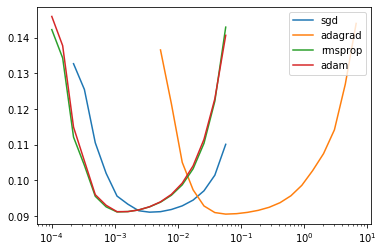

In [40]:
ax = None
BEST_STEP_SIZE = {}
BEST_GYM = {}
for name, (gym, info) in res.items():

    loss = pd.DataFrame(-gym.reward, columns=STEP_SIZE).iloc[-5000:].mean()

    BEST_STEP_SIZE[name] = loss.idxmin()
    best_idx = loss.reset_index(drop=True).idxmin()
    BEST_GYM[name] = jax.tree_map(lambda x: x[:, best_idx], gym)

    ax = loss[loss < 0.15].plot(logx=True, logy=False, ax=ax, label=name)
plt.legend()

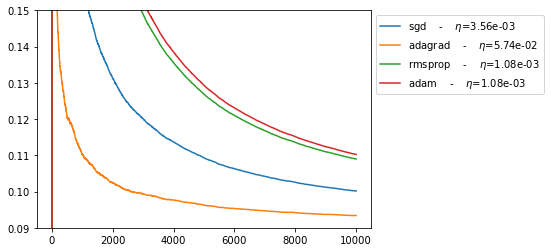

In [41]:
for name, gym in BEST_GYM.items():
    ax = (
        pd.Series(-gym.reward)
        .expanding()
        .mean()
        .plot(
            label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
        )
    )
ax.legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

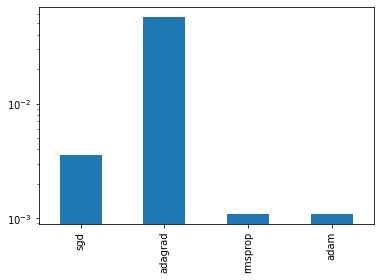

In [42]:
pd.Series(BEST_STEP_SIZE).plot(kind="bar", logy=True)

### Newton algorithm

Now let's consider the newton algorithm.

First let's test it with one set of parameter with average over N_BATCH batches.

In [43]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.05, eps=20.0)), env)(eps)


sim = unroll_transform_with_state(gym_loop_newton)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3

params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

CPU times: user 2.02 s, sys: 58.7 ms, total: 2.08 s
Wall time: 1.9 s


<AxesSubplot:>

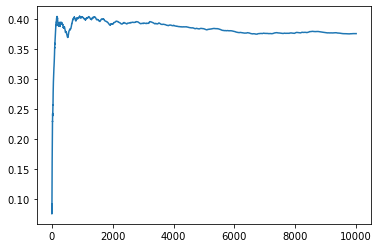

In [44]:
pd.Series(-gym.reward).expanding().mean().plot()

In [45]:
%%time

STEP_SIZE = pd.Index(onp.logspace(-2, 3, 10), name="step_size")
EPS = pd.Index(onp.logspace(-4, 3, 5), name="eps")

HPARAMS_idx = pd.MultiIndex.from_product([STEP_SIZE, EPS])
HPARAMS = jnp.stack(list(map(onp.array, HPARAMS_idx)))


@add_batch
def gym_loop_scan_hparams(eps):
    def scan_params(hparams):
        step_size, newton_eps = hparams
        agent = build_agent(opt=newton(step_size, eps=newton_eps))
        return GymFeedback(agent, env)(eps)

    return VMap(scan_params)(HPARAMS)


sim = unroll_transform_with_state(gym_loop_scan_hparams)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3

params, state = sim.init(rng, eps)
res_newton, state = sim.apply(params, state, rng, eps)

CPU times: user 21.1 s, sys: 179 ms, total: 21.2 s
Wall time: 21.1 s


In [46]:
gym_newton, info_newton = res_newton

In [47]:
loss_newton = pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).mean().unstack()

In [48]:
loss_newton = (
    pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).iloc[-5000:].mean().unstack()
)

Best newton parameters:  0.464158883361278 0.31622776601683794


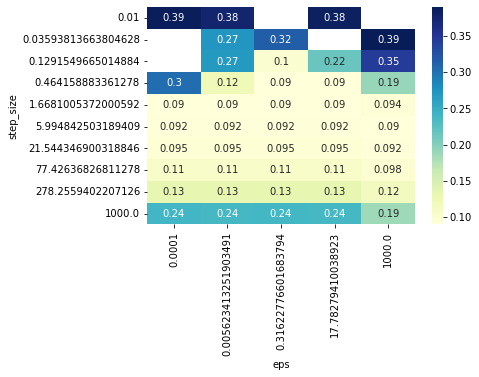

In [49]:
sns.heatmap(loss_newton[loss_newton < 0.4], annot=True, cmap="YlGnBu")

STEP_SIZE, NEWTON_EPS = loss_newton.stack().idxmin()

x = -gym_newton.reward[-5000:].mean(axis=0)
x = jax.ops.index_update(x, jnp.isnan(x), jnp.inf)
I_BEST_PARAM = jnp.argmin(x)


BEST_NEWTON_GYM = jax.tree_map(lambda x: x[:, I_BEST_PARAM], gym_newton)
print("Best newton parameters: ", STEP_SIZE, NEWTON_EPS)

Text(0.5, 1.0, 'Rolling mean of loss (5000) time-steps')

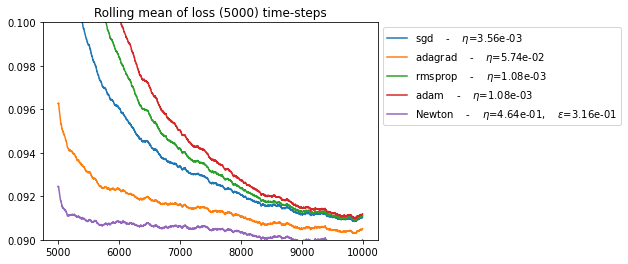

In [50]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).rolling(5000, min_periods=5000).mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.1)
    )

gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .rolling(5000, min_periods=5000)
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("Rolling mean of loss (5000) time-steps")

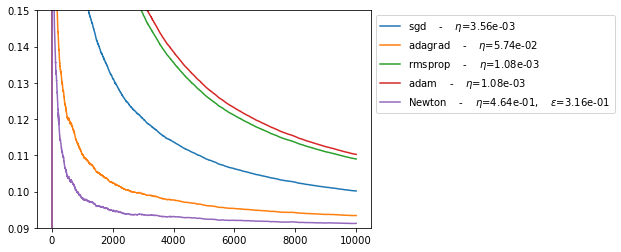

In [51]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).expanding().mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
    )
gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .expanding()
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))

In agreement with results in [1], we see that Newton's algorithm performs much better than SGD.

In addition, we note that:
- ADAGRAD performormance is between newton and sgd.
- RMSPROPR and ADAM does not perform well in this online setting.